#### 1. Importing Libraries

In [2]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from keras.layers import *
from keras.losses import *
from keras.models import *
from keras.metrics import *
from keras.optimizers import *
from keras.applications import *
from keras.utils import load_img

# For Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import pandas as pd
from tqdm import tqdm
import os
import random

In [3]:
import tensorflow as tf

# Set the seed for random number generators in numpy, random, and tensorflow
seed_value = 33
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

#### 2. Data Preparation

In [4]:
# File paths
train_csv_path = '../../../pre_processed_data/Training/train.csv'
generated_csv_path = '../../diffusion models/generated_images/generated.csv'
output_csv_path = 'all_400.csv'

# Reading CSV files
train_df = pd.read_csv(train_csv_path)
generated_df = pd.read_csv(generated_csv_path)

# Initialize final_df with train_df
final_df = train_df.copy()

# Function to add images from generated dataset
def add_images(label, count_needed):
    generated_images = generated_df[generated_df['Label'] == label]
    selected_images = generated_images.sample(n=min(count_needed, generated_images.shape[0]), random_state=42)
    return pd.concat([final_df, selected_images])

# Add images for each class
final_df = add_images('meningioma', 400)
final_df = add_images('glioma', 400)
final_df = add_images('pituitary', 400)
final_df = add_images('notumor', 400)

# Save final dataframe
final_df = final_df[['Image ID', 'Label', 'Path']]
final_df.to_csv(output_csv_path, index=False)

print(f"Saved combined data to {output_csv_path}")

Saved combined data to all_400.csv


In [5]:
len(final_df)

4807

##### 2.1 Training dataset

In [6]:
train_data = pd.read_csv("all_400.csv")

# Extracting paths and labels from the Training dataframe
train_paths = train_data['Path'].tolist()
train_labels = train_data['Label'].tolist()

# Shuffling the paths and labels
train_paths, train_labels = shuffle(train_paths, train_labels)

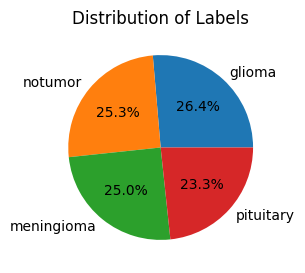

In [7]:
# Plotting a pie chart for the 'label' column
label_counts = train_data['Label'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.show()

##### 2.2 Testing dataset

In [8]:
test_data = pd.read_csv("../../../pre_processed_data/Testing/test.csv")

# Extracting paths and labels from the Testing dataframe
test_paths = test_data['Path'].tolist() 
test_labels = test_data['Label'].tolist()

# Shuffling the paths and labels
test_paths, test_labels = shuffle(test_paths, test_labels)

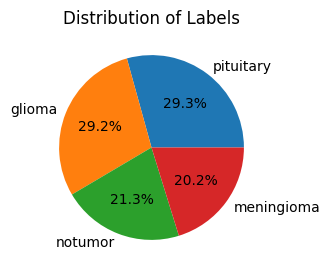

In [9]:
# Plotting a pie chart for the 'label' column
label_counts = test_data['Label'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.show()

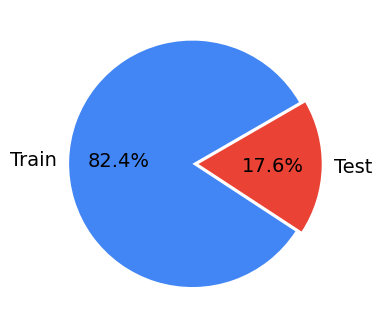

In [10]:
plt.figure(figsize=(8,4))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

##### 3.1 Examples

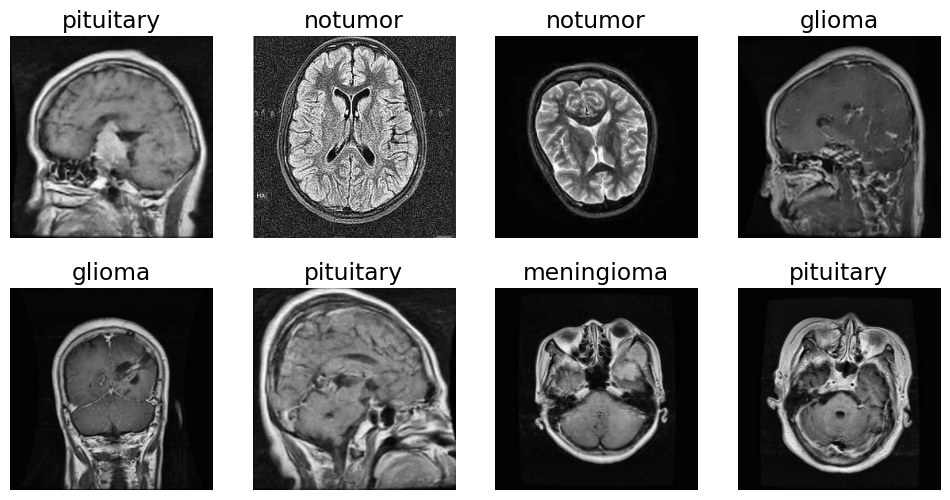

In [11]:
IMAGE_SIZE = 256

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image)  # Convert the image to a NumPy array
        images.append(image)
    return np.array(images)

# Assuming train_paths and train_labels are defined
images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

#### 4. Data Generator
Given a list of paths to images, and the labels, this function encodes the label, and then returns the batch on which the model can train on.

In [12]:
unique_labels = list(set(train_labels))

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

#### 5. Model `VGG19`

In [ ]:
base_model = VGG19(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [14]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 5
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5


150/150 [==============================] - 460s 3s/step - loss: 0.8595 - sparse_categorical_accuracy: 0.8117
Epoch 2/5
150/150 [==============================] - 476s 3s/step - loss: 0.2195 - sparse_categorical_accuracy: 0.9288
Epoch 3/5
150/150 [==============================] - 479s 3s/step - loss: 0.1557 - sparse_categorical_accuracy: 0.9502
Epoch 4/5
150/150 [==============================] - 486s 3s/step - loss: 0.1030 - sparse_categorical_accuracy: 0.9654
Epoch 5/5
150/150 [==============================] - 486s 3s/step - loss: 0.0892 - sparse_categorical_accuracy: 0.9667


#### 6. Evaluation

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.95      0.93      0.94       299
  meningioma       0.84      0.90      0.87       207
     notumor       0.99      1.00      0.99       218
   pituitary       0.98      0.94      0.96       300

    accuracy                           0.94      1024
   macro avg       0.94      0.94      0.94      1024
weighted avg       0.95      0.94      0.94      1024

